In [97]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import model_selection
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import  confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Data Loading

In [21]:
df = pd.read_csv(r"C:\Users\user\Documents\UoM\8th_semester\Neural Neworks\2η εργασία\log2.csv", engine="python")

# Data Exploration

In [22]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [23]:
df.isnull().any()

Source Port             False
Destination Port        False
NAT Source Port         False
NAT Destination Port    False
Action                  False
Bytes                   False
Bytes Sent              False
Bytes Received          False
Packets                 False
Elapsed Time (sec)      False
pkts_sent               False
pkts_received           False
dtype: bool

In [24]:
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

# Data Preprocessing

In [25]:
df['target'] = df['Action']
df['target'] = df['target'].astype(str)
df = df.drop(['Action'], axis=1)

X = df.drop(['target'], axis=1).to_numpy()
y = df['target'].astype(str)

In [26]:
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)

# Apply oversampling because of the imbalanced dataset
oversampling = SMOTE(random_state=100)
X_Smote, Y_Smote = oversampling.fit_resample(X, y)

<class 'numpy.int32'>


In [27]:
# split data to train and test
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X_Smote, Y_Smote, test_size=0.3)

# Convert target variable to categorical, to train it to the neural network
Train_Y = to_categorical(Train_Y)
Test_Y = to_categorical(Test_Y)

# Build Neural Network Model

In [61]:
model = Sequential()

model.add(Dense(64, activation="relu", input_dim=11))
model.add(Dropout(0.1))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="softmax"))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                768       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                

# Train Model

In [72]:
history = model.fit(Train_X, Train_Y, batch_size = 64, epochs = 100, validation_split=0.2)

Epoch 1/100
1318/1318 [==============================] - 4s 3ms/step - loss: 0.2226 - accuracy: 0.9137 - val_loss: 0.1916 - val_accuracy: 0.9294
Epoch 2/100
1318/1318 [==============================] - 4s 3ms/step - loss: 0.2204 - accuracy: 0.9140 - val_loss: 0.1900 - val_accuracy: 0.9283
Epoch 3/100
1318/1318 [==============================] - 4s 3ms/step - loss: 0.2176 - accuracy: 0.9165 - val_loss: 0.1886 - val_accuracy: 0.9290
Epoch 4/100
1318/1318 [==============================] - 4s 3ms/step - loss: 0.2127 - accuracy: 0.9179 - val_loss: 0.1797 - val_accuracy: 0.9299
Epoch 5/100
1318/1318 [==============================] - 4s 3ms/step - loss: 0.2102 - accuracy: 0.9189 - val_loss: 0.1767 - val_accuracy: 0.9341
Epoch 6/100
1318/1318 [==============================] - 5s 3ms/step - loss: 0.2088 - accuracy: 0.9203 - val_loss: 0.1803 - val_accuracy: 0.9292
Epoch 7/100
1318/1318 [==============================] - 5s 4ms/step - loss: 0.2060 - accuracy: 0.9205 - val_loss: 0.1737 - val_ac

1318/1318 [==============================] - 6s 5ms/step - loss: 0.1741 - accuracy: 0.9344 - val_loss: 0.1606 - val_accuracy: 0.9372
Epoch 58/100
1318/1318 [==============================] - 6s 4ms/step - loss: 0.1775 - accuracy: 0.9332 - val_loss: 0.1642 - val_accuracy: 0.9310
Epoch 59/100
1318/1318 [==============================] - 8s 6ms/step - loss: 0.1734 - accuracy: 0.9345 - val_loss: 0.1470 - val_accuracy: 0.9432
Epoch 60/100
1318/1318 [==============================] - 6s 4ms/step - loss: 0.1737 - accuracy: 0.9346 - val_loss: 0.1425 - val_accuracy: 0.9424
Epoch 61/100
1318/1318 [==============================] - 6s 4ms/step - loss: 0.1739 - accuracy: 0.9340 - val_loss: 0.1344 - val_accuracy: 0.9449
Epoch 62/100
1318/1318 [==============================] - 6s 4ms/step - loss: 0.1706 - accuracy: 0.9358 - val_loss: 0.1351 - val_accuracy: 0.9470
Epoch 63/100
1318/1318 [==============================] - 6s 5ms/step - loss: 0.1693 - accuracy: 0.9355 - val_loss: 0.1390 - val_accuracy

# Evaluate model

In [73]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 94.01%


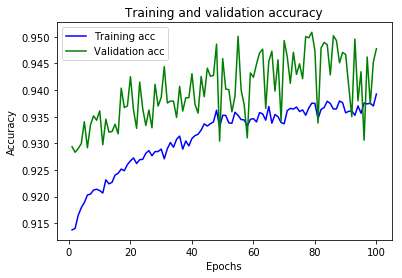

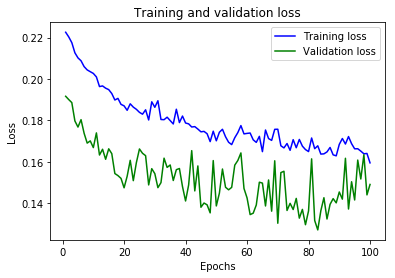

In [74]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.jpeg')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [75]:
score = model.evaluate(Test_X, Test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14988291263580322
Test accuracy: 0.9458909034729004


# Evaluate model on Test Data

In [96]:
Y_pred = model.predict(Test_X)

predicted_classes = []
for array in Y_pred:
    max_class = np.argmax(array)
    predicted_classes.append(max_class)
    
actual_classes = []
for array in Test_Y:
    max_class = np.argmax(array)
    actual_classes.append(max_class)

report = classification_report(actual_classes, predicted_classes, target_names=['allow','deny', 'drop', 'reset-both'])
cm = confusion_matrix(actual_classes, predicted_classes)



array([0.01101989, 0.01614208, 0.3339005 , ..., 0.01635722, 0.34861043,
       0.        ], dtype=float32)

In [95]:
print(report)
print(cm)

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     37640
        deny       0.99      0.87      0.93     14987
        drop       0.97      1.00      0.99     12851
  reset-both       0.03      0.89      0.06        54

    accuracy                           0.97     65532
   macro avg       0.75      0.94      0.74     65532
weighted avg       0.99      0.97      0.98     65532

[[37537    95     3     5]
 [    6 13013   330  1638]
 [    0     0 12851     0]
 [    0     6     0    48]]


TypeError: list indices must be integers or slices, not tuple

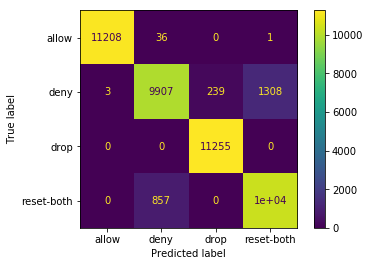

In [91]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['allow','deny', 'drop', 'reset-both'])
cmd.plot()

In [98]:
# Plot linewidth.
lw = 2

n_classes=4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Test_Y[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Test_Y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_test' is not defined

# Evaluate model on all data of the dataset

In [92]:
Y = model.predict(X)

predicted_classes = []
for array in Y:
    max_class = np.argmax(array)
    predicted_classes.append(max_class)
    
actual_classes = []
for item in y:
    actual_classes.append(item)

report = classification_report(y, predicted_classes, target_names=['allow','deny', 'drop', 'reset-both']) 
cm = confusion_matrix(y, predicted_classes)

In [93]:
print(report)
print(cm)

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     37640
        deny       0.99      0.87      0.93     14987
        drop       0.97      1.00      0.99     12851
  reset-both       0.03      0.89      0.06        54

    accuracy                           0.97     65532
   macro avg       0.75      0.94      0.74     65532
weighted avg       0.99      0.97      0.98     65532

[[37537    95     3     5]
 [    6 13013   330  1638]
 [    0     0 12851     0]
 [    0     6     0    48]]


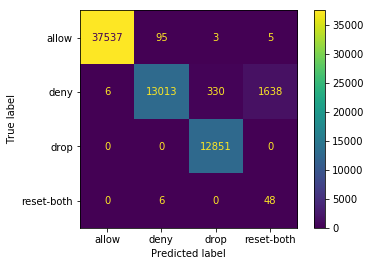

In [94]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['allow','deny', 'drop', 'reset-both'])
cmd.plot()